## Milestone 03

- Class: BDA700NAA - Health Analytics
- Subject: Health Analytics Project - Milestone 02
- Members: Ran Arino, Zubeka Dane Dang

## Data Loading

In [ ]:
# Import libraries
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize the API
api = KaggleApi()
api.authenticate()

# Download the dataset
# Format: api.dataset_download_files('username/dataset-name', path='./data')
if os.path.exists('./data/brats20-dataset-training-validation.zip'):
    print("Dataset zip file already exists in ./data directory")

elif os.path.exists('./data/brats20-dataset-training-validation'):
    print("Dataset directory already exists in ./data directory")
else:
    api.dataset_download_files('awsaf49/brats20-dataset-training-validation', path='./data')
    print("Dataset downloaded to ./data directory")


In [25]:
import numpy as np # linear algebra
import os

import matplotlib.pyplot as plt
import nibabel as nib
import torch
from torch.utils.data import Dataset
from scipy.ndimage import zoom
import os

## Codes for Model Metics and Preprocessing

In [55]:
# Metrics

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou(y_true, y_pred):
    smooth = 1e-6
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def precision(y_true, y_pred):
    smooth = 1e-6
    true_positive = np.sum(y_true * y_pred)
    predicted_positive = np.sum(y_pred)
    return (true_positive + smooth) / (predicted_positive + smooth)

def recall(y_true, y_pred):
    smooth = 1e-6
    true_positive = np.sum(y_true * y_pred)
    actual_positive = np.sum(y_true)
    return (true_positive + smooth) / (actual_positive + smooth)


In [52]:
class BraTSDataset(Dataset):
    def __init__(self, root_dir, validation=False, new_size=None, slice_num=None):
        self.root_dir = root_dir
        self.new_size = new_size # Store new_size
        self.slice_num = slice_num # Store slice_num

        if validation:
            self.subject_dirs = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.startswith("BraTS20_Validation")]
        else:
            self.subject_dirs = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.startswith("BraTS20_Training")]

    def __len__(self):
        return len(self.subject_dirs)

    def __getitem__(self, idx):
        subject_path = self.subject_dirs[idx]
        flair = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_flair.nii')).get_fdata()
        t1 = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_t1.nii')).get_fdata()
        t1ce = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_t1ce.nii')).get_fdata()
        t2 = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_t2.nii')).get_fdata()

        # Select middle slices
        if self.slice_num:
            start_slice = (flair.shape[2] - self.slice_num) // 2
            end_slice = start_slice + self.slice_num
            flair = flair[:, :, start_slice:end_slice]
            t1 = t1[:, :, start_slice:end_slice]
            t1ce = t1ce[:, :, start_slice:end_slice]
            t2 = t2[:, :, start_slice:end_slice]

        # For training data, we load segmentation masks
        if 'Training' in os.path.basename(subject_path):
            seg = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_seg.nii')).get_fdata()
            if self.slice_num:
                start_slice = (seg.shape[2] - self.slice_num) // 2
                end_slice = start_slice + self.slice_num
                seg = seg[:, :, start_slice:end_slice]

            # Extract tumor sub-regions
            et = (seg == 4).astype(float)  # Enhancing Tumor
            ed = (seg == 2).astype(float)  # Edema
            ncr_net = (seg == 1).astype(float)  # Necrotic/Non-enhancing Tumor
            segmentation = torch.tensor([et, ed, ncr_net], dtype=torch.float32)
        else:
            # No segmentation for validation data
            segmentation = None
    
        # Stack modalities along the channel dimension
        image = torch.tensor([flair, t1, t1ce, t2], dtype=torch.float32)
        image = np.array(image)

        if self.new_size:
            image = self._resize_or_crop(image, self.new_size, keep_depth=True)
            if segmentation is not None:
                segmentation = np.array(segmentation)
                segmentation = self._resize_or_crop(segmentation, self.new_size, keep_depth=True)

        # Convert back to tensor
        image = torch.tensor(image, dtype=torch.float32)
        if segmentation is not None:
            segmentation = torch.tensor(segmentation, dtype=torch.long)
            segmentation = torch.argmax(segmentation, dim=0).long()



        return image, segmentation
    
    def _resize_or_crop(self, data, new_size, keep_depth=False):
        if isinstance(new_size, int):
            # Resize to a square image, keeping depth unchanged
            new_shape = (data.shape[0], new_size, new_size, data.shape[3]) if keep_depth else (data.shape[0], new_size, new_size, new_size)
            data = self._resize(data, new_shape)
        elif isinstance(new_size, tuple) and len(new_size) == 3:
            # Resize to a specific 3D size
            new_shape = (data.shape[0], *new_size)
            data = self._resize(data, new_shape)
        elif isinstance(new_size, tuple) and len(new_size) == 2:
            # Center crop to new_size, keeping depth unchanged
            data = self._center_crop(data, new_size)
        else:
            raise ValueError("new_size should be an int or a tuple of length 2 or 3.")

        return data

    def _resize(self, data, new_shape):
        # Use scipy.ndimage.zoom for resizing
        zoom_factors = [n / o for n, o in zip(new_shape, data.shape)]
        return zoom(data, zoom_factors, order=1)  # Linear interpolation

    def _center_crop(self, image, new_size):
        # Implement a simple center crop
        _, h, w, d = image.shape
        new_h, new_w = new_size
        start_h = (h - new_h) // 2
        start_w = (w - new_w) // 2
        return image[:, start_h:start_h+new_h, start_w:start_w+new_w, :]


# Set dataset paths (adjust these paths based on where your data is extracted)
# train_dataset_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
train_dataset_path = "./data/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Create datasets
train_dataset = BraTSDataset(train_dataset_path, new_size=(150, 150), slice_num=20)

# Testing the datasets
print("\nTesting Training Dataset:")
for i in range(1):
    try:
        image, segmentation = train_dataset[i]
        print(f"Loaded training sample {i} successfully")
        print(f"Image shape: {image.shape}")
        print(f"Segmentation shape: {segmentation.shape}")
    except FileNotFoundError as e:
        print(f"Error: {e}")


Testing Training Dataset:
Loaded training sample 0 successfully
Image shape: torch.Size([4, 150, 150, 20])
Segmentation shape: torch.Size([150, 150, 20])


/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:50: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(image)
/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:55: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  segmentation = np.array(segmentation)


In [53]:
# Load training data
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
torch.manual_seed(42)
train_subset, test_subset = random_split(train_dataset, [train_size, test_size])
train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

## Model Development

Using device: cpu


Epoch 1/50:   0%|          | 0/294 [00:00<?, ?batch/s]

/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:50: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(image)
/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:55: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  segmentation = np.array(segmentation)
Epoch 1/50: 100%|██████████| 294/294 [21:28<00:00,  4.38s/batch, Loss=1.1949, Dice=0.1258, IoU=0.0671, Precision=0.0682, Recall=0.8101]


Epoch [1/50], Train Loss: 1.2956, Val Loss: 3.1469, Train Dice: 0.1386, Val Dice: 0.1484, Train IoU: 0.0789, Val IoU: 0.0995, Train Precision: 0.0760, Val Precision: 0.1145, Train Recall: 1.4182, Val Recall: 0.6775


Epoch 2/50: 100%|██████████| 294/294 [21:27<00:00,  4.38s/batch, Loss=1.1051, Dice=0.1322, IoU=0.0708, Precision=0.0715, Recall=0.8730]


Epoch [2/50], Train Loss: 1.1548, Val Loss: 1.5387, Train Dice: 0.1843, Val Dice: 0.1425, Train IoU: 0.1103, Val IoU: 0.1185, Train Precision: 0.1121, Val Precision: 0.7928, Train Recall: 0.8992, Val Recall: 0.2480


Epoch 3/50: 100%|██████████| 294/294 [21:43<00:00,  4.43s/batch, Loss=1.0124, Dice=0.6881, IoU=0.5245, Precision=0.6508, Recall=0.7300]


Epoch [3/50], Train Loss: 1.0622, Val Loss: 1.4689, Train Dice: 0.5142, Val Dice: 0.2958, Train IoU: 0.4156, Val IoU: 0.2325, Train Precision: 0.4925, Val Precision: 0.6635, Train Recall: 0.7593, Val Recall: 0.3773


Epoch 4/50: 100%|██████████| 294/294 [22:21<00:00,  4.56s/batch, Loss=0.9277, Dice=0.8980, IoU=0.8148, Precision=0.9396, Recall=0.8599]


Epoch [4/50], Train Loss: 0.9777, Val Loss: 1.2242, Train Dice: 0.6363, Val Dice: 0.3333, Train IoU: 0.5408, Val IoU: 0.2786, Train Precision: 0.6754, Val Precision: 0.8429, Train Recall: 0.7364, Val Recall: 0.4486


Epoch 5/50: 100%|██████████| 294/294 [21:28<00:00,  4.38s/batch, Loss=0.8574, Dice=0.4762, IoU=0.3125, Precision=0.3562, Recall=0.7182]


Epoch [5/50], Train Loss: 0.8965, Val Loss: 1.1141, Train Dice: 0.6933, Val Dice: 0.2266, Train IoU: 0.6292, Val IoU: 0.2208, Train Precision: 0.7483, Val Precision: 0.8997, Train Recall: 0.7761, Val Recall: 0.2806


Epoch 6/50: 100%|██████████| 294/294 [22:12<00:00,  4.53s/batch, Loss=0.7984, Dice=0.8193, IoU=0.6939, Precision=0.8378, Recall=0.8016]


Epoch [6/50], Train Loss: 0.8257, Val Loss: 0.8706, Train Dice: 0.7077, Val Dice: 0.2931, Train IoU: 0.6448, Val IoU: 0.2575, Train Precision: 0.7914, Val Precision: 0.9405, Train Recall: 0.7542, Val Recall: 0.3090


Epoch 7/50: 100%|██████████| 294/294 [23:11<00:00,  4.73s/batch, Loss=0.7274, Dice=0.4770, IoU=0.3132, Precision=0.8097, Recall=0.3381]


Epoch [7/50], Train Loss: 0.7668, Val Loss: 0.8525, Train Dice: 0.6784, Val Dice: 0.2931, Train IoU: 0.5961, Val IoU: 0.2332, Train Precision: 0.8084, Val Precision: 0.9512, Train Recall: 0.6909, Val Recall: 0.2881


Epoch 8/50: 100%|██████████| 294/294 [22:47<00:00,  4.65s/batch, Loss=0.6692, Dice=0.9500, IoU=0.9048, Precision=0.9754, Recall=0.9259]


Epoch [8/50], Train Loss: 0.7123, Val Loss: 0.8272, Train Dice: 0.6471, Val Dice: 0.1910, Train IoU: 0.5349, Val IoU: 0.1533, Train Precision: 0.8419, Val Precision: 0.9269, Train Recall: 0.5992, Val Recall: 0.1972


Epoch 9/50: 100%|██████████| 294/294 [22:26<00:00,  4.58s/batch, Loss=0.6285, Dice=0.6124, IoU=0.4414, Precision=0.7457, Recall=0.5196]


Epoch [9/50], Train Loss: 0.6699, Val Loss: 0.7180, Train Dice: 0.6303, Val Dice: 0.0854, Train IoU: 0.5136, Val IoU: 0.0692, Train Precision: 0.8528, Val Precision: 1.0383, Train Recall: 0.5687, Val Recall: 0.0691


Epoch 10/50: 100%|██████████| 294/294 [21:43<00:00,  4.43s/batch, Loss=0.6014, Dice=0.6917, IoU=0.5287, Precision=0.7930, Recall=0.6133]


Epoch [10/50], Train Loss: 0.6300, Val Loss: 0.6931, Train Dice: 0.6501, Val Dice: 0.0219, Train IoU: 0.5393, Val IoU: 0.0185, Train Precision: 0.8863, Val Precision: 0.9761, Train Recall: 0.5739, Val Recall: 0.0274


Epoch 11/50: 100%|██████████| 294/294 [20:43<00:00,  4.23s/batch, Loss=0.5584, Dice=0.0000, IoU=0.0000, Precision=1.0000, Recall=0.0000]


Epoch [11/50], Train Loss: 0.5986, Val Loss: 0.6474, Train Dice: 0.6629, Val Dice: 0.2714, Train IoU: 0.5628, Val IoU: 0.2704, Train Precision: 0.8944, Val Precision: 1.0472, Train Recall: 0.5927, Val Recall: 0.2341


Epoch 12/50: 100%|██████████| 294/294 [23:22<00:00,  4.77s/batch, Loss=0.5621, Dice=0.8171, IoU=0.6908, Precision=0.9704, Recall=0.7057]


Epoch [12/50], Train Loss: 0.5736, Val Loss: 0.6336, Train Dice: 0.6801, Val Dice: 0.0215, Train IoU: 0.5978, Val IoU: 0.0186, Train Precision: 0.9165, Val Precision: 1.0064, Train Recall: 0.6031, Val Recall: 0.0211


Epoch 13/50: 100%|██████████| 294/294 [23:16<00:00,  4.75s/batch, Loss=0.5143, Dice=0.7534, IoU=0.6044, Precision=0.8268, Recall=0.6920]


Epoch [13/50], Train Loss: 0.5504, Val Loss: 0.6677, Train Dice: 0.6984, Val Dice: 0.3815, Train IoU: 0.6265, Val IoU: 0.3246, Train Precision: 0.9330, Val Precision: 0.9834, Train Recall: 0.6156, Val Recall: 0.3391
EarlyStopping counter: 1 out of 5


Epoch 14/50: 100%|██████████| 294/294 [22:54<00:00,  4.68s/batch, Loss=0.4942, Dice=0.5417, IoU=0.3715, Precision=0.6927, Recall=0.4448]


Epoch [14/50], Train Loss: 0.5305, Val Loss: 0.6394, Train Dice: 0.7182, Val Dice: 0.3374, Train IoU: 0.6613, Val IoU: 0.2924, Train Precision: 0.9505, Val Precision: 0.9708, Train Recall: 0.6369, Val Recall: 0.3041
EarlyStopping counter: 2 out of 5


Epoch 15/50: 100%|██████████| 294/294 [20:42<00:00,  4.23s/batch, Loss=0.5185, Dice=1.0449, IoU=1.0941, Precision=1.2944, Recall=0.8761]


Epoch [15/50], Train Loss: 0.5148, Val Loss: 0.6649, Train Dice: 0.7281, Val Dice: 0.3888, Train IoU: 0.6776, Val IoU: 0.3302, Train Precision: 0.9591, Val Precision: 1.0122, Train Recall: 0.6509, Val Recall: 0.3718
EarlyStopping counter: 3 out of 5


Epoch 16/50: 100%|██████████| 294/294 [20:51<00:00,  4.26s/batch, Loss=0.4871, Dice=1.0141, IoU=1.0286, Precision=1.1678, Recall=0.8961]


Epoch [16/50], Train Loss: 0.5015, Val Loss: 0.6258, Train Dice: 0.7360, Val Dice: 0.4525, Train IoU: 0.6984, Val IoU: 0.4370, Train Precision: 0.9806, Val Precision: 0.7857, Train Recall: 0.6494, Val Recall: 0.5714


Epoch 17/50: 100%|██████████| 294/294 [21:07<00:00,  4.31s/batch, Loss=0.4866, Dice=0.8906, IoU=0.8027, Precision=1.0567, Recall=0.7696]


Epoch [17/50], Train Loss: 0.4884, Val Loss: 0.7322, Train Dice: 0.7572, Val Dice: 0.4631, Train IoU: 0.7399, Val IoU: 0.4347, Train Precision: 1.0041, Val Precision: 0.6248, Train Recall: 0.6675, Val Recall: 0.6840
EarlyStopping counter: 1 out of 5


Epoch 18/50: 100%|██████████| 294/294 [21:18<00:00,  4.35s/batch, Loss=0.4759, Dice=0.9136, IoU=0.8409, Precision=0.9957, Recall=0.8440]


Epoch [18/50], Train Loss: 0.4797, Val Loss: 0.6222, Train Dice: 0.7522, Val Dice: 0.4575, Train IoU: 0.7269, Val IoU: 0.4494, Train Precision: 0.9784, Val Precision: 0.8299, Train Recall: 0.6619, Val Recall: 0.5296


Epoch 19/50: 100%|██████████| 294/294 [21:24<00:00,  4.37s/batch, Loss=0.4850, Dice=0.9862, IoU=0.9728, Precision=1.2232, Recall=0.8261]


Epoch [19/50], Train Loss: 0.4717, Val Loss: 0.7319, Train Dice: 0.7661, Val Dice: 0.4520, Train IoU: 0.7484, Val IoU: 0.4354, Train Precision: 1.0039, Val Precision: 0.8006, Train Recall: 0.6779, Val Recall: 0.5531
EarlyStopping counter: 1 out of 5


Epoch 20/50: 100%|██████████| 294/294 [21:22<00:00,  4.36s/batch, Loss=0.5475, Dice=1.0512, IoU=1.1080, Precision=1.7131, Recall=0.7583]


Epoch [20/50], Train Loss: 0.4633, Val Loss: 0.7035, Train Dice: 0.7766, Val Dice: 0.4740, Train IoU: 0.7706, Val IoU: 0.4505, Train Precision: 1.0184, Val Precision: 0.7147, Train Recall: 0.6825, Val Recall: 0.5931
EarlyStopping counter: 2 out of 5


Epoch 21/50: 100%|██████████| 294/294 [21:42<00:00,  4.43s/batch, Loss=0.4497, Dice=0.6633, IoU=0.4962, Precision=0.6356, Recall=0.6935]


Epoch [21/50], Train Loss: 0.4572, Val Loss: 0.6497, Train Dice: 0.7889, Val Dice: 0.4074, Train IoU: 0.7955, Val IoU: 0.3341, Train Precision: 1.0298, Val Precision: 0.7986, Train Recall: 0.6972, Val Recall: 0.3946
EarlyStopping counter: 3 out of 5


Epoch 22/50: 100%|██████████| 294/294 [21:43<00:00,  4.43s/batch, Loss=0.5343, Dice=1.0796, IoU=1.1730, Precision=1.4981, Recall=0.8439]


Epoch [22/50], Train Loss: 0.4506, Val Loss: 0.6075, Train Dice: 0.7937, Val Dice: 0.4551, Train IoU: 0.8048, Val IoU: 0.4330, Train Precision: 1.0409, Val Precision: 0.9109, Train Recall: 0.6960, Val Recall: 0.4668


Epoch 23/50: 100%|██████████| 294/294 [21:46<00:00,  4.45s/batch, Loss=0.4701, Dice=0.8038, IoU=0.6719, Precision=0.9710, Recall=0.6857]


Epoch [23/50], Train Loss: 0.4436, Val Loss: 0.8985, Train Dice: 0.8196, Val Dice: 0.2471, Train IoU: 0.8502, Val IoU: 0.1605, Train Precision: 1.0676, Val Precision: 0.2792, Train Recall: 0.7103, Val Recall: 0.8469
EarlyStopping counter: 1 out of 5


Epoch 24/50: 100%|██████████| 294/294 [21:55<00:00,  4.47s/batch, Loss=0.4248, Dice=1.1321, IoU=1.3045, Precision=1.4729, Recall=0.9194]


Epoch [24/50], Train Loss: 0.4427, Val Loss: 0.5572, Train Dice: 0.7912, Val Dice: 0.1325, Train IoU: 0.8120, Val IoU: 0.1168, Train Precision: 1.0167, Val Precision: 1.1104, Train Recall: 0.6988, Val Recall: 0.0986


Epoch 25/50: 100%|██████████| 294/294 [21:52<00:00,  4.46s/batch, Loss=0.4016, Dice=0.5509, IoU=0.3802, Precision=0.8776, Recall=0.4015]


Epoch [25/50], Train Loss: 0.4397, Val Loss: 0.8026, Train Dice: 0.7913, Val Dice: 0.2992, Train IoU: 0.7991, Val IoU: 0.2132, Train Precision: 1.0424, Val Precision: 0.3344, Train Recall: 0.6985, Val Recall: 0.8600
EarlyStopping counter: 1 out of 5


Epoch 26/50: 100%|██████████| 294/294 [21:52<00:00,  4.46s/batch, Loss=0.4179, Dice=0.7951, IoU=0.6599, Precision=1.1857, Recall=0.5981]


Epoch [26/50], Train Loss: 0.4322, Val Loss: 0.7130, Train Dice: 0.8211, Val Dice: 0.2988, Train IoU: 0.8659, Val IoU: 0.2211, Train Precision: 1.0605, Val Precision: 0.4597, Train Recall: 0.7266, Val Recall: 0.5846
EarlyStopping counter: 2 out of 5


Epoch 27/50: 100%|██████████| 294/294 [21:56<00:00,  4.48s/batch, Loss=0.4449, Dice=1.0887, IoU=1.1947, Precision=1.5262, Recall=0.8461]


Epoch [27/50], Train Loss: 0.4290, Val Loss: 0.6739, Train Dice: 0.8152, Val Dice: 0.4576, Train IoU: 0.8599, Val IoU: 0.4351, Train Precision: 1.0492, Val Precision: 0.7516, Train Recall: 0.7232, Val Recall: 0.5972
EarlyStopping counter: 3 out of 5


Epoch 28/50: 100%|██████████| 294/294 [21:56<00:00,  4.48s/batch, Loss=0.3961, Dice=0.5530, IoU=0.3822, Precision=0.9844, Recall=0.3845]


Epoch [28/50], Train Loss: 0.4242, Val Loss: 1.0478, Train Dice: 0.8341, Val Dice: 0.2251, Train IoU: 0.8976, Val IoU: 0.1431, Train Precision: 1.0744, Val Precision: 0.2288, Train Recall: 0.7378, Val Recall: 1.0889
EarlyStopping counter: 4 out of 5


Epoch 29/50: 100%|██████████| 294/294 [21:55<00:00,  4.48s/batch, Loss=0.4191, Dice=1.3528, IoU=2.0901, Precision=1.6697, Recall=1.1369]


Epoch [29/50], Train Loss: 0.4231, Val Loss: 1.4303, Train Dice: 0.8299, Val Dice: 0.2519, Train IoU: 0.8885, Val IoU: 0.1678, Train Precision: 1.0617, Val Precision: 0.1845, Train Recall: 0.7397, Val Recall: 1.1709
EarlyStopping counter: 5 out of 5
Early stopping triggered


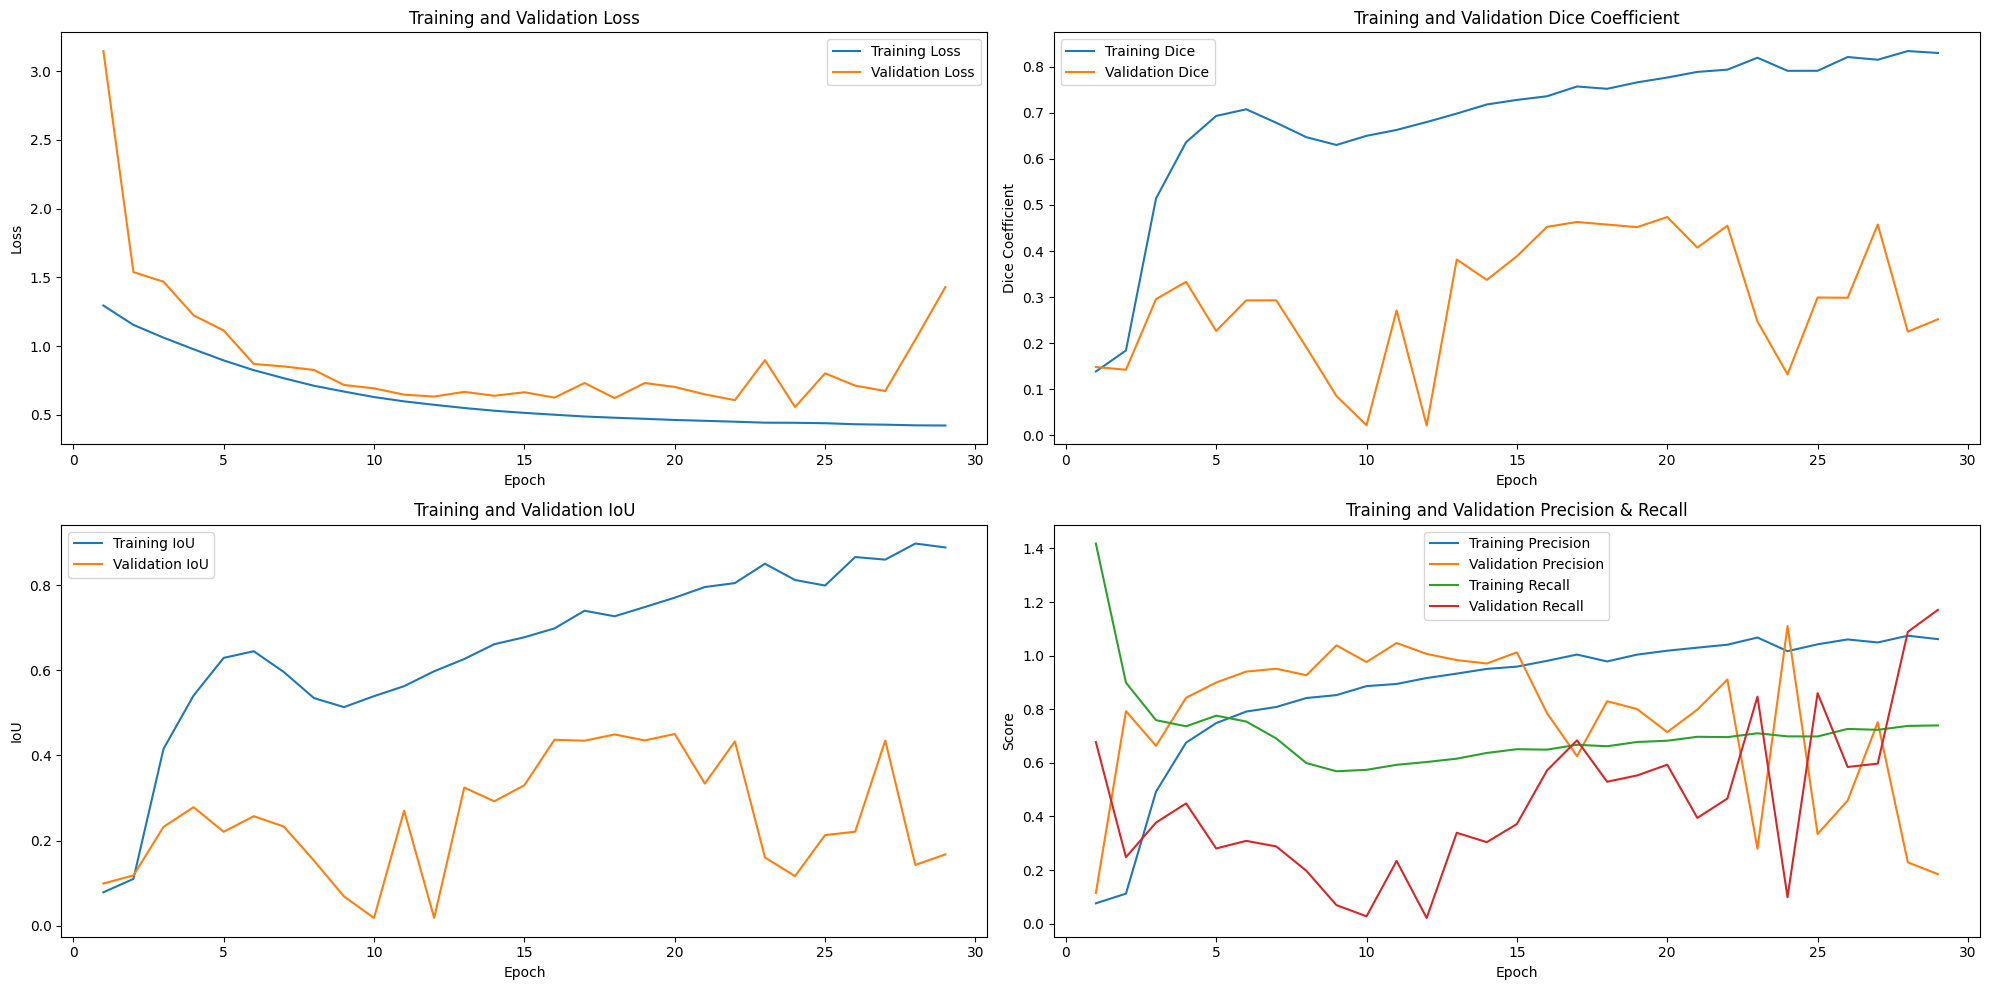

Model saved as unet3d_brats20.pth


In [56]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()

        def CBR3d(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm3d(out_ch),
                nn.ReLU(inplace=True)
            )

        # Encoding path
        self.enc1 = nn.Sequential(CBR3d(in_channels, 16), CBR3d(16, 32))
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = nn.Sequential(CBR3d(32, 32), CBR3d(32, 64))
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = nn.Sequential(CBR3d(64, 64), CBR3d(64, 128))
        self.pool3 = nn.MaxPool3d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(CBR3d(128, 128), CBR3d(128, 128))  # Compression here

        # Decoding path
        self.up3 = nn.ConvTranspose3d(128, 128, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(CBR3d(256, 128), CBR3d(128, 64))
        self.up2 = nn.ConvTranspose3d(64, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(CBR3d(128, 64), CBR3d(64, 32))
        self.up1 = nn.ConvTranspose3d(32, 32, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(CBR3d(64, 32), CBR3d(32, 16))

        # Output layer
        self.out = nn.Conv3d(16, out_channels, kernel_size=1)

    def forward(self, x):
        # Check input size before each pooling operation
        if x.size(2) < 2 or x.size(3) < 2 or x.size(4) < 2:
            raise ValueError("Input size is too small for pooling operations.")

        # Encoding path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))

        # Decoding path with dynamic padding
        dec3_up = self.up3(bottleneck)
        enc3_padded = self._pad_if_needed(dec3_up, enc3)
        dec3 = self.dec3(torch.cat((dec3_up, enc3_padded), dim=1))

        dec2_up = self.up2(dec3)
        enc2_padded = self._pad_if_needed(dec2_up, enc2)
        dec2 = self.dec2(torch.cat((dec2_up, enc2_padded), dim=1))

        dec1_up = self.up1(dec2)
        enc1_padded = self._pad_if_needed(dec1_up, enc1)
        dec1 = self.dec1(torch.cat((dec1_up, enc1_padded), dim=1))

        # Output layer
        out = self.out(dec1)

        # Dynamically adjust output dimensions to match input
        out = self._resize_output(out, x)

        return out

    def _pad_if_needed(self, upsampled, encoder_feature):
        """
        Pads the encoder_feature to match the spatial dimensions of upsampled tensor.
        """
        diff_depth = upsampled.size(2) - encoder_feature.size(2)
        diff_height = upsampled.size(3) - encoder_feature.size(3)
        diff_width = upsampled.size(4) - encoder_feature.size(4)

        enc_padded = F.pad(
            encoder_feature,
            [
                diff_width // 2, diff_width - diff_width // 2,
                diff_height // 2, diff_height - diff_height // 2,
                diff_depth // 2, diff_depth - diff_depth // 2
            ]
        )
        return enc_padded

    def _resize_output(self, out, x):
        """
        Adjusts the output dimensions to match the input dimensions.
        """
        desired_size = x.size()[2:]
        current_size = out.size()[2:]

        pad_depth = desired_size[0] - current_size[0]
        pad_height = desired_size[1] - current_size[1]
        pad_width = desired_size[2] - current_size[2]

        padding = [
            0, max(pad_width, 0),
            0, max(pad_height, 0),
            0, max(pad_depth, 0)
        ]

        if pad_width > 0 or pad_height > 0 or pad_depth > 0:
            out = F.pad(out, padding)

        if pad_width < 0 or pad_height < 0 or pad_depth < 0:
            out = out[:, :, :desired_size[0], :desired_size[1], :desired_size[2]]

        return out

# Define the 3D UNet model
in_channels = 4  # Number of input modalities (FLAIR, T1, T1ce, T2)
out_channels = 4  # Number of output classes (Background, NCR/NET, ED, ET)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = UNet3D(in_channels, out_channels).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
accumulation_steps = 2
criterion = nn.CrossEntropyLoss()

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
train_metrics = {'dice': [], 'iou': [], 'precision': [], 'recall': []}
val_metrics = {'dice': [], 'iou': [], 'precision': [], 'recall': []}  # Dictionary to store metrics
early_stopping = EarlyStopping(patience=5, min_delta=1e-4)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_metrics = {'dice': 0, 'iou': 0, 'precision': 0, 'recall': 0}

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        optimizer.zero_grad()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps  # Normalize loss for gradient accumulation
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            epoch_loss += loss.item() * accumulation_steps

            # Calculate Metrics for the batch
            predicted_segmentation = torch.argmax(outputs, dim=1).cpu().numpy()
            true_segmentation = labels.cpu().numpy()
            epoch_metrics['dice'] += dice_coefficient(true_segmentation, predicted_segmentation)
            epoch_metrics['iou'] += iou(true_segmentation, predicted_segmentation)
            epoch_metrics['precision'] += precision(true_segmentation, predicted_segmentation)
            epoch_metrics['recall'] += recall(true_segmentation, predicted_segmentation)

            # Update Progress Bar
            pbar.set_postfix({
                'Loss': f"{loss.item()*accumulation_steps:.4f}",
                'Dice': f"{dice_coefficient(true_segmentation, predicted_segmentation):.4f}",
                'IoU': f"{iou(true_segmentation, predicted_segmentation):.4f}",
                'Precision': f"{precision(true_segmentation, predicted_segmentation):.4f}",
                'Recall': f"{recall(true_segmentation, predicted_segmentation):.4f}"
            })
            pbar.update(1)

    avg_train_loss = epoch_loss / len(train_loader)
    avg_train_dice = epoch_metrics['dice'] / len(train_loader)
    avg_train_iou = epoch_metrics['iou'] / len(train_loader)
    avg_train_precision = epoch_metrics['precision'] / len(train_loader)
    avg_train_recall = epoch_metrics['recall'] / len(train_loader)

    train_losses.append(avg_train_loss)
    train_metrics['dice'].append(avg_train_dice)
    train_metrics['iou'].append(avg_train_iou)
    train_metrics['precision'].append(avg_train_precision)
    train_metrics['recall'].append(avg_train_recall)

    # Validation Phase
    model.eval()
    val_loss = 0
    val_metrics_current = {'dice': 0, 'iou': 0, 'precision': 0, 'recall': 0}
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate Metrics for the batch
            predicted_segmentation = torch.argmax(outputs, dim=1).cpu().numpy()
            true_segmentation = labels.cpu().numpy()
            val_metrics_current['dice'] += dice_coefficient(true_segmentation, predicted_segmentation)
            val_metrics_current['iou'] += iou(true_segmentation, predicted_segmentation)
            val_metrics_current['precision'] += precision(true_segmentation, predicted_segmentation)
            val_metrics_current['recall'] += recall(true_segmentation, predicted_segmentation)

    avg_val_loss = val_loss / len(test_loader)
    avg_val_dice = val_metrics_current['dice'] / len(test_loader)
    avg_val_iou = val_metrics_current['iou'] / len(test_loader)
    avg_val_precision = val_metrics_current['precision'] / len(test_loader)
    avg_val_recall = val_metrics_current['recall'] / len(test_loader)

    val_losses.append(avg_val_loss)
    val_metrics['dice'].append(avg_val_dice)
    val_metrics['iou'].append(avg_val_iou)
    val_metrics['precision'].append(avg_val_precision)
    val_metrics['recall'].append(avg_val_recall)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}, "
          f"Train IoU: {avg_train_iou:.4f}, Val IoU: {avg_val_iou:.4f}, "
          f"Train Precision: {avg_train_precision:.4f}, Val Precision: {avg_val_precision:.4f}, "
          f"Train Recall: {avg_train_recall:.4f}, Val Recall: {avg_val_recall:.4f}")

    # Early Stopping Check
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# Plotting the Metrics
plt.figure(figsize=(20, 10))

# Loss Plot
plt.subplot(2, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Dice Score Plot
plt.subplot(2, 2, 2)
plt.plot(range(1, len(train_metrics['dice'])+1), train_metrics['dice'], label='Training Dice')
plt.plot(range(1, len(val_metrics['dice'])+1), val_metrics['dice'], label='Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.legend()

# IoU Plot
plt.subplot(2, 2, 3)
plt.plot(range(1, len(train_metrics['iou'])+1), train_metrics['iou'], label='Training IoU')
plt.plot(range(1, len(val_metrics['iou'])+1), val_metrics['iou'], label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()

# Precision and Recall Plot
plt.subplot(2, 2, 4)
plt.plot(range(1, len(train_metrics['precision'])+1), train_metrics['precision'], label='Training Precision')
plt.plot(range(1, len(val_metrics['precision'])+1), val_metrics['precision'], label='Validation Precision')
plt.plot(range(1, len(train_metrics['recall'])+1), train_metrics['recall'], label='Training Recall')
plt.plot(range(1, len(val_metrics['recall'])+1), val_metrics['recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training and Validation Precision & Recall')
plt.legend()

plt.tight_layout()
plt.show()


# Save the model
torch.save(model.state_dict(), 'unet3d_brats20.pth')
print("Model saved as unet3d_brats20.pth")

## Comparing the Model's Predictions

In [107]:
def show_sample_comparison(model, dataset, index, device, slice_idx=None):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Get the sample from the dataset
        image, true_segmentation = dataset[index]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Get the model prediction
        predicted_segmentation = model(image)
        predicted_segmentation = torch.argmax(predicted_segmentation, dim=1).squeeze().cpu().numpy()
     
        # Convert true segmentation to numpy for plotting
        true_segmentation = true_segmentation.squeeze().cpu().numpy()
     
        # Determine the slice index to visualize
        if slice_idx is None:
            slice_idx = image.shape[-1] // 2  # Default to the middle slice

        # Plot the results
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(image.squeeze().cpu().numpy()[0, :, :, slice_idx], cmap='gray')  # Show one modality
        axes[0].set_title('Input Image (FLAIR)')
        axes[0].axis('off')

        axes[1].imshow(true_segmentation[:, :, slice_idx], cmap='gray')
        axes[1].set_title('True Segmentation')
        axes[1].axis('off')

        axes[2].imshow(predicted_segmentation[:, :, slice_idx], cmap='gray')
        axes[2].set_title('Predicted Segmentation')
        axes[2].axis('off')

        plt.show()

### Good Predictions

/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:50: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(image)
/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:55: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  segmentation = np.array(segmentation)


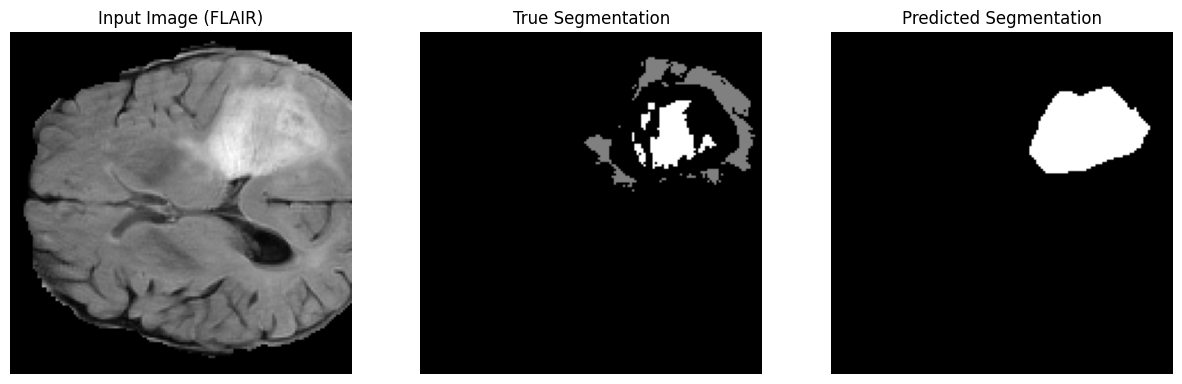

In [118]:
# Example (Good)
show_sample_comparison(model, test_subset, index=3, device=device)

/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:50: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(image)
/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:55: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  segmentation = np.array(segmentation)


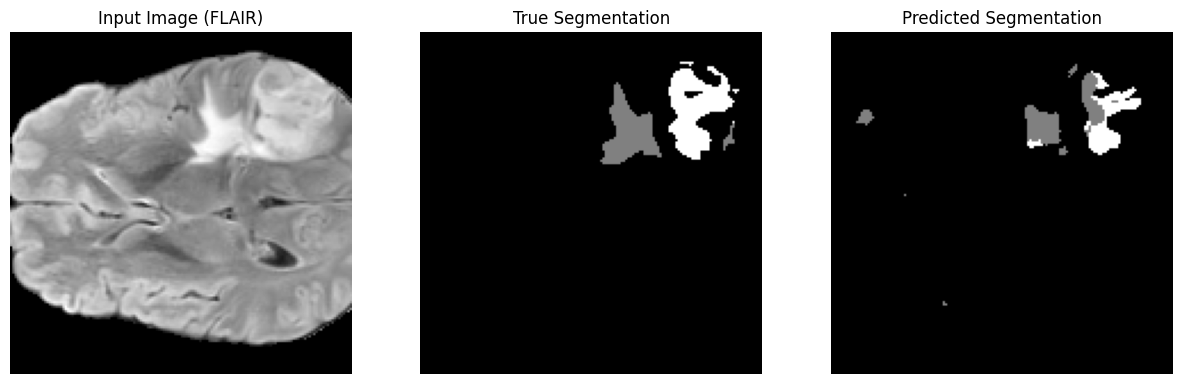

In [140]:
# Example (Good)
show_sample_comparison(model, test_subset, index=55, device=device)

/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:50: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(image)
/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:55: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  segmentation = np.array(segmentation)


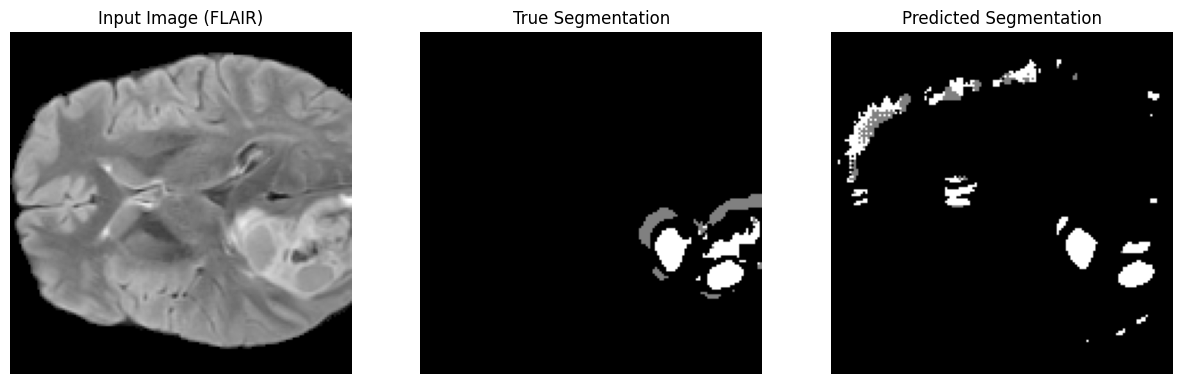

In [126]:
# Example (Good)
show_sample_comparison(model, test_subset, index=68, device=device)

### Bad Predictions

/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:50: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(image)
/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:55: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  segmentation = np.array(segmentation)


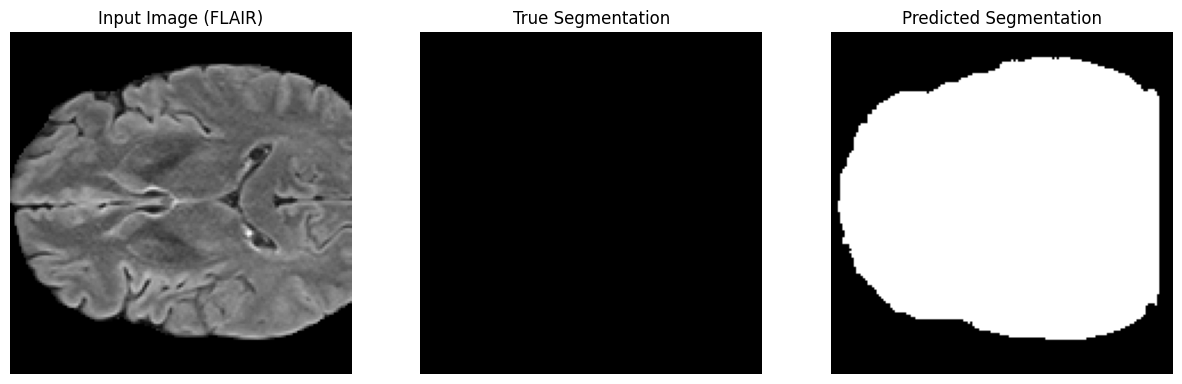

In [153]:
# Example (Bad)
show_sample_comparison(model, test_subset, index=20, device=device)

/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:50: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(image)
/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:55: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  segmentation = np.array(segmentation)


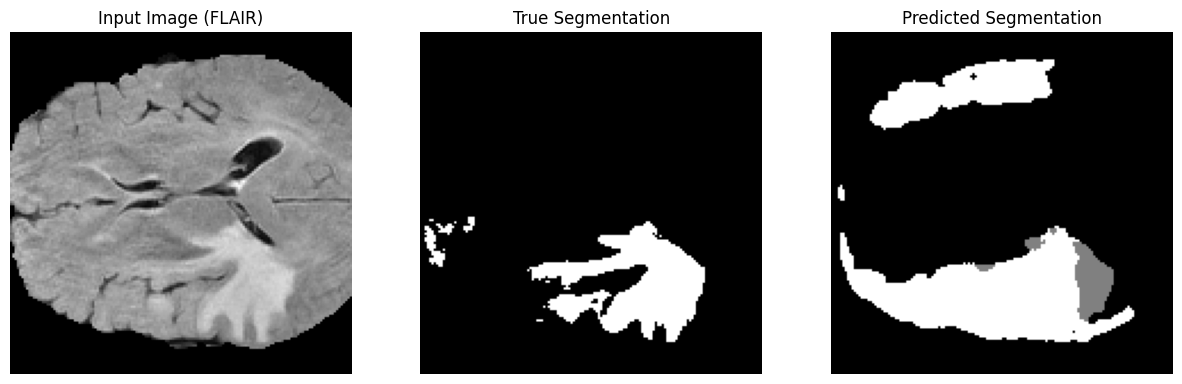

In [152]:
# Example (Bad)
show_sample_comparison(model, test_subset, index=43, device=device)

/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:50: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(image)
/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:55: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  segmentation = np.array(segmentation)


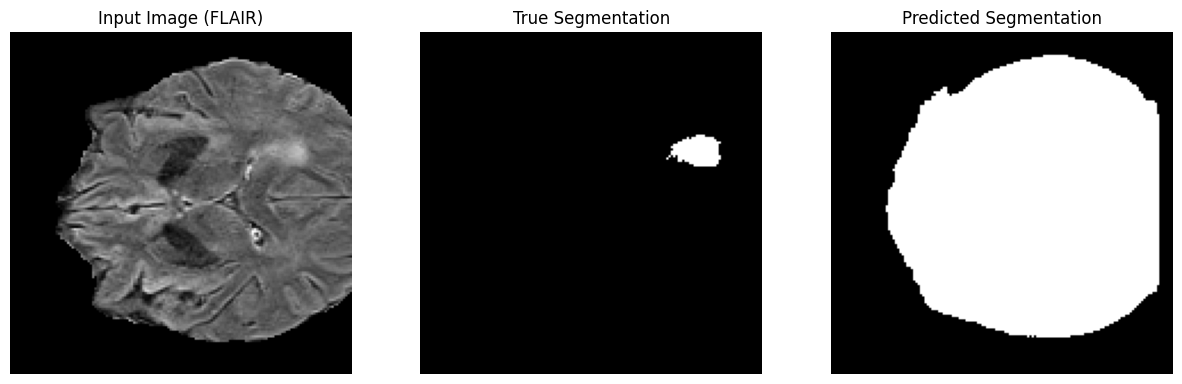

In [145]:
# Example (Bad)
show_sample_comparison(model, test_subset, index=51, device=device)

/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:50: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(image)
/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_36668/3851815928.py:55: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  segmentation = np.array(segmentation)


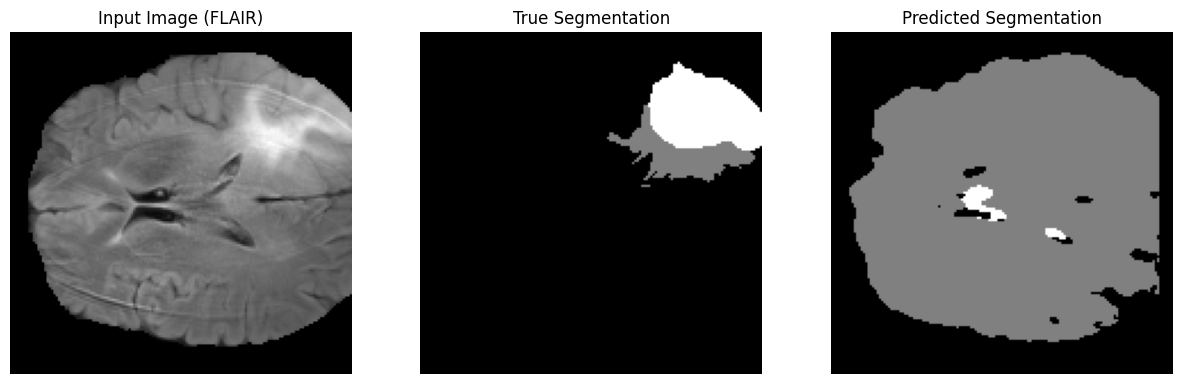

In [117]:
# Example usage (Bad)
show_sample_comparison(model, test_subset, index=21, device=device)